# Predicting California’s Groundwater Levels Using Machine Learning for Sustainable Management

In [459]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Fetching the Groundwater Level Measurements via the CA Dept. of Water Resources API

In [460]:
# Fetch data from API
def fetch_groundwater_data():
    sql_query = "SELECT * FROM \"231ba173-392a-4f62-91fb-07f4a90746d1\" WHERE county_name = 'Fresno'"
    url = f"https://data.ca.gov/api/3/action/datastore_search_sql?sql={sql_query}"

    response = requests.get(url)
    
    # Check if request was successful
    if response.status_code == 200:
        data = response.json()
        records = data['result']['records']
        df = pd.DataFrame(records)
        
        # Print basic details
        print("\nData Successfully Fetched!")
        print(f"Total Records Retrieved: {len(df)}")
        print("\nPreview of Data:\n", df.head())  # Print first few rows
        
        return df
    else:
        print("Failed to fetch data. Status Code:", response.status_code)
        return None

# Call function and print results
df = fetch_groundwater_data()

# Optional: Display full column names to understand the dataset better
if df is not None:
    print("\nColumns in DataFrame:\n", df.columns.tolist())


print(f"Total Number of Rows in Dataset: {df.shape[0]}")



Data Successfully Fetched!
Total Records Retrieved: 50000

Preview of Data:
        _id                                         _full_text  \
0  1452966  '-022.10':27 '-03':4 '-12':3 '00':5,6,7 '1986'...   
1  1452970  '-022.10':25 '-12':3 '-16':4 '00':5,6,7 '1981'...   
2  1452971  '-01':3 '-02':4 '-022.10':27 '00':5,6,7 '1979'...   
3  1452972  '-02':3 '-022.10':25 '-03':4 '00':5,6,7 '1978'...   
4  1452973  '-022.10':25 '-12':3 '-21':4 '00':5,6,7 '1976'...   

            site_code            msmt_date  wlm_rpe  wlm_gse      gwe  \
0  361192N1202716W001  1986-12-03T00:00:00  608.050  607.050  314.050   
1  361192N1202716W001  1981-12-16T00:00:00  608.050  607.050  315.050   
2  361192N1202716W001  1979-01-02T00:00:00  608.050  607.050     None   
3  361192N1202716W001  1978-02-03T00:00:00  608.050  607.050  348.050   
4  361192N1202716W001  1976-12-21T00:00:00  608.050  607.050  354.050   

   gse_gwe   wlm_qa_desc             wlm_qa_detail wlm_mthd_desc wlm_acc_desc  \
0  293.000 

## Fetch and Focus on Fresno County data for better accuracy and less variability

In [461]:
# Call function and get DataFrame
df_fresno = fetch_groundwater_data()

# Save to CSV (optional)
if df_fresno is not None:
    save_csv = True  # Set to False if you don't want to save
    if save_csv:
        df_fresno.to_csv("fresno_groundwater.csv", index=False)
        print("\Fresno County data saved as 'fresno_groundwater.csv'")


Data Successfully Fetched!
Total Records Retrieved: 50000

Preview of Data:
        _id                                         _full_text  \
0  1801717  '-022.07':25 '-06':4 '-10':3 '00':5,6,7 '132.4...   
1  1452970  '-022.10':25 '-12':3 '-16':4 '00':5,6,7 '1981'...   
2  1452971  '-01':3 '-02':4 '-022.10':27 '00':5,6,7 '1979'...   
3  1452972  '-02':3 '-022.10':25 '-03':4 '00':5,6,7 '1978'...   
4  1452973  '-022.10':25 '-12':3 '-21':4 '00':5,6,7 '1976'...   

            site_code            msmt_date  wlm_rpe  wlm_gse      gwe  \
0  366222N1202557W002  1993-10-06T00:00:00  168.070  167.570  132.470   
1  361192N1202716W001  1981-12-16T00:00:00  608.050  607.050  315.050   
2  361192N1202716W001  1979-01-02T00:00:00  608.050  607.050     None   
3  361192N1202716W001  1978-02-03T00:00:00  608.050  607.050  348.050   
4  361192N1202716W001  1976-12-21T00:00:00  608.050  607.050  354.050   

   gse_gwe wlm_qa_desc             wlm_qa_detail wlm_mthd_desc wlm_acc_desc  \
0   35.100   

## Missing Values Analysis

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_42939/4281829942.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")


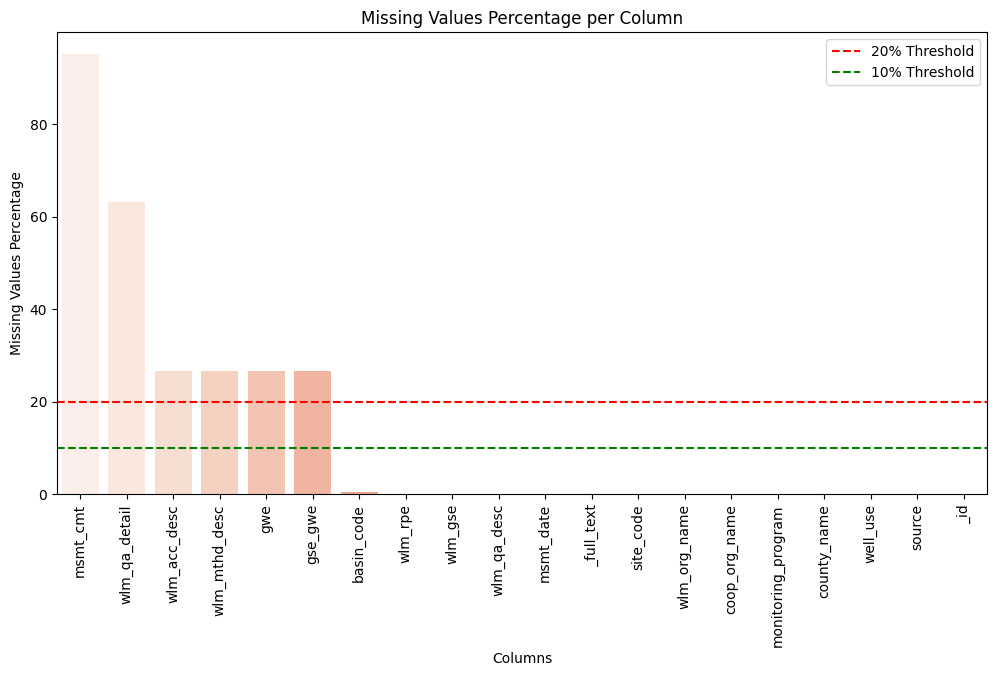

In [462]:
# Load the dataset
file_path = "./fresno_groundwater.csv"

# Read the dataset
df = pd.read_csv(file_path)

# Calculate missing values percentage per column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Percentage': missing_percentage
}).sort_values(by="Missing Percentage", ascending=False)

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")
plt.xticks(rotation=90)
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.axhline(y=10, color='green', linestyle='--', label='10% Threshold')
plt.ylabel("Missing Values Percentage")
plt.xlabel("Columns")
plt.title("Missing Values Percentage per Column")
plt.legend()
plt.show()



## Cleaning the data

/var/folders/z2/ns_w84j13gdbd48gnvk2np5c0000gn/T/ipykernel_42939/1533608455.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")


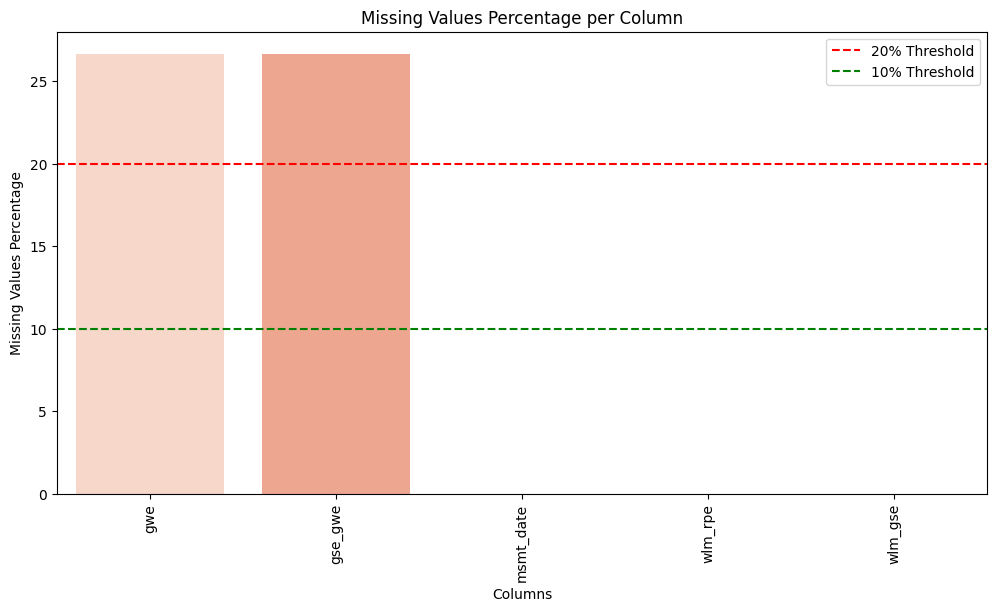

Cleaned dataset saved as 'cleaned_dataset.csv'
              Column  Missing Percentage
gwe              gwe               26.66
gse_gwe      gse_gwe               26.66
msmt_date  msmt_date                0.00
wlm_rpe      wlm_rpe                0.00
wlm_gse      wlm_gse                0.00


In [463]:
# Drop unnecessary columns
columns_to_remove = ["msmt_cmt", "wlm_qa_detail", "wlm_org_name", "coop_org_name", "monitoring_program", "county_name", "source", "well_use", "_id", "_full_text", "site_code", "wlm_qa_desc", "wlm_mthd_desc", "wlm_acc_desc", "basin_code"]
df_cleaned = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

# Remove columns that contain only zeros and are text-based columns like descriptions, IDs, etc.
df_cleaned = df_cleaned.loc[:, (df_cleaned != 0).any(axis=0)]

# Calculate missing values percentage per column
missing_values = df_cleaned.isnull().sum()
missing_percentage = (missing_values / len(df_cleaned)) * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df_cleaned.columns,
    'Missing Percentage': missing_percentage
}).sort_values(by="Missing Percentage", ascending=False)

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x="Column", y="Missing Percentage", data=missing_df, palette="Reds")
plt.xticks(rotation=90)
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.axhline(y=10, color='green', linestyle='--', label='10% Threshold')
plt.ylabel("Missing Values Percentage")
plt.xlabel("Columns")
plt.title("Missing Values Percentage per Column")
plt.legend()
plt.show()

# Save the cleaned dataset (optional)
df_cleaned.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

# Display missing values analysis
print(missing_df)

## Function to plot the data per type of variables

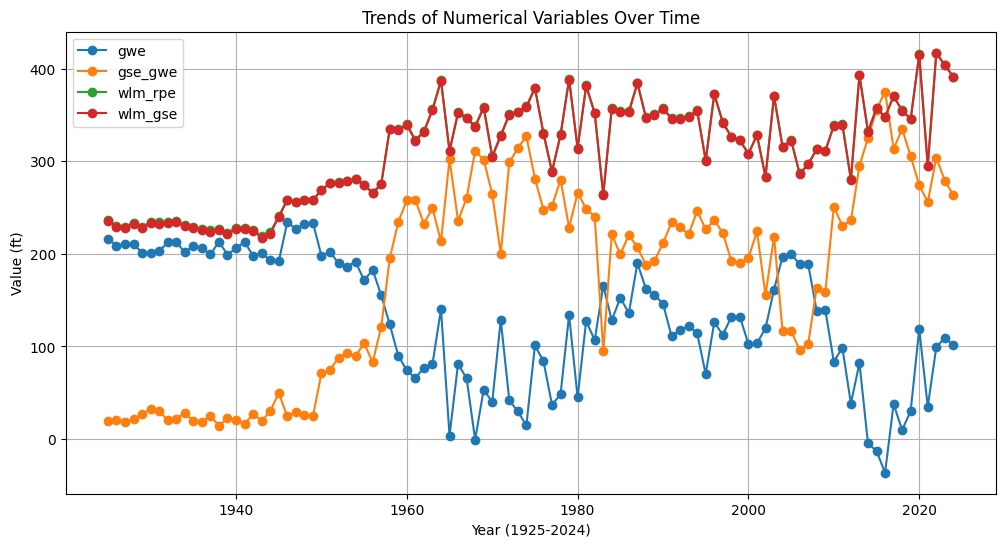

In [464]:
def plot_numerical_trends(df, variables, date_column="msmt_date"):
    # Ensure date column is in datetime format
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df["year"] = df[date_column].dt.year  # Extract year
    else:
        print(f"Date column '{date_column}' not found.")
        return
    
    # Keep only numerical columns from the provided variable list
    numeric_vars = [var for var in variables if var in df.columns and pd.api.types.is_numeric_dtype(df[var])]
    
    if not numeric_vars:
        print("No numerical variables found for plotting.")
        return

    # Create a line plot for each numerical variable over the years
    plt.figure(figsize=(12, 6))
    for var in numeric_vars:
        yearly_avg = df.groupby("year")[var].mean()  # Aggregate by year
        plt.plot(yearly_avg.index, yearly_avg.values, marker="o", label=var)

    plt.xlabel("Year (1925-2024)")
    plt.ylabel("Value (ft)")
    plt.title("Trends of Numerical Variables Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the variables to analyze
variables = [
    "wlm_mthd_desc", "wlm_acc_desc", "gwe", "gse_gwe", "msmt_date", "wlm_rpe", "wlm_gse", "wlm_qa_desc"
]

# Load your dataset
file_path = "cleaned_dataset.csv" 
df = pd.read_csv(file_path)

# Call the function
plot_numerical_trends(df, variables)



## Resample Dataframe to work with monthly value

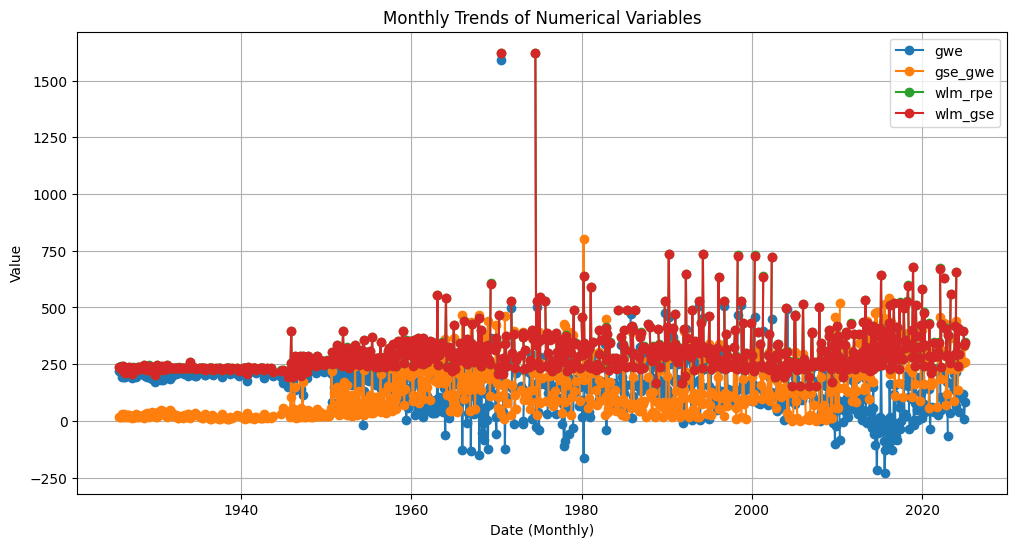

In [465]:
def plot_monthly_trends(df, variables, date_column="msmt_date"):
    # Ensure date column is in datetime format
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df.set_index(date_column, inplace=True)  # Set date as index
    else:
        print(f"Date column '{date_column}' not found.")
        return
    
    # Keep only numerical columns from the provided variable list
    numeric_vars = [var for var in variables if var in df.columns and pd.api.types.is_numeric_dtype(df[var])]
    
    if not numeric_vars:
        print("No numerical variables found for plotting.")
        return

    # Resample data by month and compute mean values
    df_resampled = df[numeric_vars].resample('M').mean()

    # Plot monthly trends
    plt.figure(figsize=(12, 6))
    for var in numeric_vars:
        plt.plot(df_resampled.index, df_resampled[var], marker="o", label=var)

    plt.xlabel("Date (Monthly)")
    plt.ylabel("Value")
    plt.title("Monthly Trends of Numerical Variables")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the variables to analyze
variables = [
    "wlm_mthd_desc", "wlm_acc_desc", "gwe", "gse_gwe", "msmt_date", "wlm_rpe", "wlm_gse", "wlm_qa_desc"
]

# Load your dataset
file_path = "cleaned_dataset.csv"  # Replace with actual file path
df = pd.read_csv(file_path)

# Call the function
plot_monthly_trends(df, variables)


## Feature Engineering

### Time-Based Feature (Extract from msmt_date)

In [466]:
# Standardize column names (remove spaces and convert to lowercase)
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower()

# Check if 'msmt_date' exists (for debugging)
print("Columns in cleaned dataset:", df_cleaned.columns.tolist())

# Convert 'msmt_date' to datetime if available
if 'msmt_date' in df_cleaned.columns:
    df_cleaned['msmt_date'] = pd.to_datetime(df_cleaned['msmt_date'], errors='coerce')
    df_cleaned['year'] = df_cleaned['msmt_date'].dt.year
    df_cleaned['month'] = df_cleaned['msmt_date'].dt.month
    df['gwe_last_month'] = df['gwe'].shift(1)  # Lag feature
    print("Successfully processed 'msmt_date'.")
else:
    print("'msmt_date' not found in cleaned dataset!")


Columns in cleaned dataset: ['msmt_date', 'wlm_rpe', 'wlm_gse', 'gwe', 'gse_gwe']
Successfully processed 'msmt_date'.


### Water Depth & Elevation Features

In [448]:
df['water_table_depth'] = df['gse_gwe']
df['rolling_mean_gwe_3'] = df['gwe'].rolling(window=3).mean()
df['rolling_mean_gwe_6'] = df['gwe'].rolling(window=6).mean()


### Data Cleaning & Transformation

In [449]:
scaler = MinMaxScaler()
df[['gwe', 'water_table_depth']] = scaler.fit_transform(df[['gwe', 'water_table_depth']])

### One-hot encoding

In [467]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure the test set has the same columns as the train set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [468]:
print("Missing values in X_train:")
print(pd.DataFrame(X_train).isnull().sum().sort_values(ascending=False))

print("\nMissing values in X_test:")
print(pd.DataFrame(X_test).isnull().sum().sort_values(ascending=False))


Missing values in X_train:
gse_gwe    11529
wlm_rpe        0
wlm_gse        0
dtype: int64

Missing values in X_test:
gse_gwe    2008
wlm_rpe       0
wlm_gse       0
dtype: int64


In [469]:
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train.loc[X_train.index]  # Align target variable
y_test = y_test.loc[X_test.index]


In [470]:
print("Missing values in X_train:")
print(pd.DataFrame(X_train).isnull().sum().sort_values(ascending=False))

print("\nMissing values in X_test:")
print(pd.DataFrame(X_test).isnull().sum().sort_values(ascending=False))


Missing values in X_train:
wlm_rpe    0
wlm_gse    0
gse_gwe    0
dtype: int64

Missing values in X_test:
wlm_rpe    0
wlm_gse    0
gse_gwe    0
dtype: int64


## Machine Learning

### Split into training and test data set

In [471]:
print(df.columns)  # Ensure 'msmt_date' exists
print(df.index.name)  # Should print 'msmt_date' if it's set as the index


df.reset_index(inplace=True)  # Moves 'msmt_date' from index to a regular column
print(df.columns)  # Now 'msmt_date' should appear in columns


Index(['wlm_rpe', 'wlm_gse', 'gwe', 'gse_gwe', 'gwe_last_month'], dtype='object')
msmt_date
Index(['msmt_date', 'wlm_rpe', 'wlm_gse', 'gwe', 'gse_gwe', 'gwe_last_month'], dtype='object')


In [472]:

# Convert msmt_date to datetime and set as index
df['msmt_date'] = pd.to_datetime(df['msmt_date'], errors='coerce')
df.set_index('msmt_date', inplace=True)

# Split the dataframe into training (2005-2016) and testing (2017+)
df_train = df[(df.index >= '1925-01-01') & (df.index < '2010-01-01')]
df_test = df[df.index >= '2017-01-01']

# Print dataset shape details
print("Shape of Training Data:", df_train.shape)
print("Shape of Testing Data:", df_test.shape)
print("Training Data Contains {:.2f}% of the Total Data".format((df_train.shape[0] * 100) / df.shape[0]))


Shape of Training Data: (37379, 5)
Shape of Testing Data: (6020, 5)
Training Data Contains 74.76% of the Total Data


In [473]:
# Define the target variables
target_variables = ['gwe', 'gse_gwe', 'wlm_rpe', 'wlm_gse']  # Replace with actual target column names

# Split features (X) and target variables (y) for training
X_train = df_train.drop(columns=target_variables, axis=1)
y_train_gwe = df_train['gwe'].values  # Replace with actual column names
y_train_gse_gwe = df_train['gse_gwe'].values
y_train_wlm_rpe = df_train['wlm_rpe'].values

# Split features (X) and target variables (y) for testing
X_test = df_test.drop(columns=target_variables, axis=1)
y_test_gwe = df_test['gwe'].values
y_test_gse_gwe = df_test['gse_gwe'].values
y_test_wlm_rpe = df_test['wlm_rpe'].values

# Print the shapes to verify correctness
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_gwe shape:", y_train_gwe.shape)
print("y_test_gwe shape:", y_test_gwe.shape)


X_train shape: (37379, 1)
X_test shape: (6020, 1)
y_train_gwe shape: (37379,)
y_test_gwe shape: (6020,)


### Scale the data

In [474]:

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform "X_train"
X_train_scaled = scaler.fit_transform(X_train)

# Transform "X_test" using the same scaler
X_test_scaled = scaler.transform(X_test)

# Print shapes to confirm
print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_test shape:", X_test_scaled.shape)


Scaled X_train shape: (37379, 1)
Scaled X_test shape: (6020, 1)


## Training the models

In [475]:
# Re-import necessary libraries due to execution state reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to calculate performance metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse}

# Load dataset (Ensure it is scaled)
file_path = "cleaned_dataset.csv"  # Adjusted file path
df = pd.read_csv(file_path)

# Convert date column to datetime and set as index
df['msmt_date'] = pd.to_datetime(df['msmt_date'], errors='coerce')
df.set_index('msmt_date', inplace=True)

# Define features and target
target = "gwe"  # Change if necessary
feature_columns = [col for col in df.columns if col != target] 

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df[target], test_size=0.2, random_state=42, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = []

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest"))

# Train XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost"))

# Train Gradient Boosting (LightGBM)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_gb, "Gradient Boosting"))

# Reshape data for deep learning models (CNN & LSTM need 3D input)
X_train_dl = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_dl, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_cnn = cnn_model.predict(X_test_dl).flatten()
results.append(evaluate_model(y_test, y_pred_cnn, "CNN"))

# Train LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_dl.shape[1], 1)),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_dl, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_dl).flatten()
results.append(evaluate_model(y_test, y_pred_lstm, "LSTM"))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
import ace_tools as tools
tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=results_df)


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Look for the rainfall data as well for producing higher accracy in the model. Otherwise, it would just be predicting based on historical data thats available. Considere adding temprature of a particular place (Fresno County) to better the analyze the accuracy scores. 



